<a href="https://colab.research.google.com/github/juninhoisrael/deteccao-de-fraude/blob/main/Previs%C3%A3o_de_fraudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de fraudes em serviços de pagamento financeiro
Considerando que o objetivo dos fraudadores em geral é terem benefícios monetários, torna evidente que o setor financeiro é um dos seus principais alvos. Mesmo o crescente investimento em ações preventivas e de monitoramento não têm sido suficientes para barrar ou frear a escalada dos criminosos. De acordo com a Psafe (https://www.psafe.com/), de janeiro a agosto do ano passado foram 920 mil casos somente no Brasil e a cada minuto, 3,6 fraudes acontecem no país. Foram detectados, por exemplo, mais de 11 milhões de tentativas de fishing bancário.

A indústria financeira possui grande representatividade no Brasil e no mundo. Para se ter uma ideia, os ativos dos bancos no Brasil somam R$ 7,4 trilhões, superando o próprio PIB do país (Infomoney)(https://www.infomoney.com.br/economia/ativos-de-bancos-somam-r-74-trilhoes-e-superam-pib-brasileiro/), 25-05-2020).

 De acordo com a ABECS(https://www.abecs.org.br/) (Associação Brasileira das Empresas de Cartão de Crédito e Serviços), foram movimentados R$ 558 bilhões  no primeiro trimestre de 2021 e os cartões de crédito representaram R$ 335 bilhões desse total. Foram 6,5 bilhões de transações, um crescimento de 11,8%, com destaque para cartão de débito que apresentou aumento de 163% (veja quadros abaixo). Apesar da opulência destes números, o impacto das fraudes é igualmente gritante. Os crimes cibernéticos, considerando apenas transações de cartão de crédito, já projetavam em 2018 um impacto de 6 trilhões de dólares de perda de receita até 2021 ao redor do mundo.
Neste cenário, a inteligência artificial surge como uma ferramenta que dá mais robustez, agilidade e flexibilidade para combater a fraude, trabalhando 24 horas por dia, 7 dias por semana, tornando-se um caminho mais do que possível, necessário para que as instituições financeiras possam combater de forma efetiva os fraudadores. Um exemplo disso é a American Express, com mais de 115 milhões de cartões de crédito ativos, que combate às fraudes utilizando inferência e Deep Learning, reduzindo gastos relacionados a fraudes em U$ 1,2 trilhões, em processos de detecção que acontecem em milisegundos. Fato que garante à empresa o menor índice de fraudes no mundo por 13 anos consecutivos.

# Preparação do Ambiente

Nesta seção vamos importar os pacotes que são necessários para a execução deste notebook.


## Importação dos pacotes em Python

In [133]:
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para tratamento de dados em cpu
import pandas as pd
import numpy as np

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para treinamento e cálculo de métricas em CPU
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split as cpu_train_test_split
from sklearn.ensemble import RandomForestClassifier as cpu_RandomForestClassifier
from sklearn.metrics import accuracy_score as cpu_accuracy_score
from sklearn.metrics import confusion_matrix as cpu_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
                             f1_score, roc_auc_score, confusion_matrix, \
                             classification_report

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

validacao = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1)
from sklearn.metrics import precision_recall_curve, plot_roc_curve, auc, average_precision_score

# Algoritmo XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
# Evita que o pandas apresente valores em notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Carregamento do Dataset

Nesta seção estamos carregando o dataset de fraudes em transações bancárias a partir do google drive.

In [3]:
%%time
from google.colab import drive # Caso a leitura desse código seja feito pelo Colab, será necessário importar do drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TERA/desafio classificação/fraud.csv')  # Leitura do Banco de dados 
display(data.head(2))
data.head(2)

Mounted at /content/drive


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0


CPU times: user 17.8 s, sys: 3.47 s, total: 21.3 s
Wall time: 1min 6s


Dicionário
- step - Passo: representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744 (30 dias);

- type - Tipo: tipo de transação (depósito, saque, débito, pagamento e transferência);

- amount - Quantia: total que foi transacionado;

- nameOrig - ClienteOrigem: cliente que iniciou a transação

- oldbalanceOrg - SaldoInicialOrigem: saldo da conta de origem antes da transação;

- newbalanceOrig - SaldoFinalOrigem: saldo da conta de origem após a transação;

- nameDest - ClienteDestino: cliente de destino da transação;

- oldbalanceDest - SaldoInicialDestino: saldo da conta de destino antes da transação;

- newbalanceDest - SaldoFinalDestino: saldo da conta de destino após a transação;

- isFraud - ÉFraude: flag que define se a transação é fraudulenta ou não. Nesta simulação o objetivo da fraude é assumir a conta do usuário, esvaziá-la transferindo para outra conta e então sacando o dinheiro.

- isFlaggedFraud - SinalizadaComoFraude: automaticamente marcadas pelo banco como fraude por tentarem transferir mais de 200.000 em uma única transação.

In [4]:
%%time
data.columns # Verificação das colunas

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 18.6 µs


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## Avaliando o dataset

In [5]:
%%time
data.type.unique() #Identificar valores únicos da série tipos de transação

CPU times: user 336 ms, sys: 1.5 ms, total: 337 ms
Wall time: 343 ms


array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [6]:
%%time
data.info() # Observação geral do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
CPU times: user 11.3 ms, sys: 2.7 ms, total: 14.1 ms
Wall time: 26.2 ms


In [7]:
%%time
# Verifica valores faltantes
data.isnull().sum()

CPU times: user 1.13 s, sys: 24.8 ms, total: 1.16 s
Wall time: 1.14 s


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Análise Exploratória

In [8]:
%%time
data.describe()

CPU times: user 1.9 s, sys: 25.8 ms, total: 1.93 s
Wall time: 1.93 s


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000
mean,243.39725,179861.90355,833883.10407,855113.66858,1100701.66652,1224996.39820,0.00129,0.00000
std,142.33197,603858.23146,2888242.67301,2924048.50297,3399180.11297,3674128.94209,0.03590,0.00159
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,156.00000,13389.57000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,239.00000,74871.94000,14208.00000,0.00000,132705.66500,214661.44000,0.00000,0.00000
75%,335.00000,208721.47750,107315.17500,144258.41000,943036.70750,1111909.25000,0.00000,0.00000
max,743.00000,92445516.64000,59585040.37000,49585040.37000,356015889.35000,356179278.92000,1.00000,1.00000


In [9]:
%%time
data.shape

CPU times: user 47 µs, sys: 8 µs, total: 55 µs
Wall time: 60.3 µs


(6362620, 11)

In [10]:
%%time
# Drop Duplicates
data.drop_duplicates(keep=False, inplace=True)

CPU times: user 25 s, sys: 249 ms, total: 25.3 s
Wall time: 26.9 s


CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


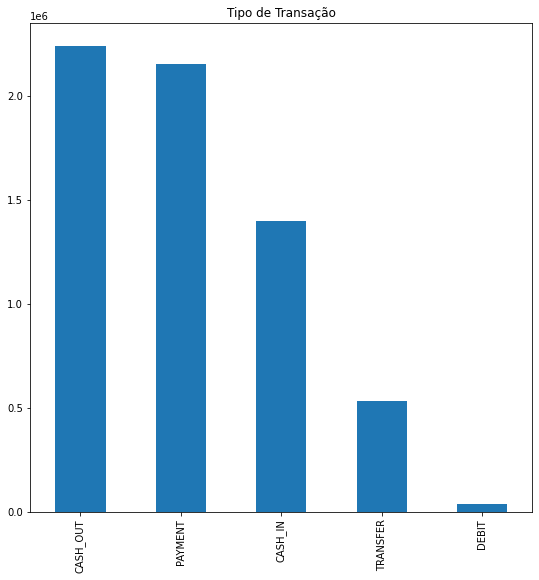

In [11]:
print(data.type.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 8))
data.type.value_counts().plot(kind='bar', title="Tipo de Transação", ax=ax, figsize=(9,9))
plt.show()

Podemos observar que existem 5 tipos de transações são elas:
- Cash_out ou Saques
- Payment ou Pagamentos
- Cash_In ou Depósitos
- Transfer ou Transferência
- Debit ou Débito.
-Bastante desbalanceado, visto que os 3 primeiros tipos representam a maioria dos dados.


Podemos observar também duas colunas bastante interessantes para essa análise.
- isFraud ou é fraude( Representa um indicador que indica se a transação é ou não fraude)
- isFlaggedFraud ou Fraude sinalizada ( Representa os casos de transação onde o sistema prevê como fraude a partir de limites pré-estabelecidos pelo estabelicimento)

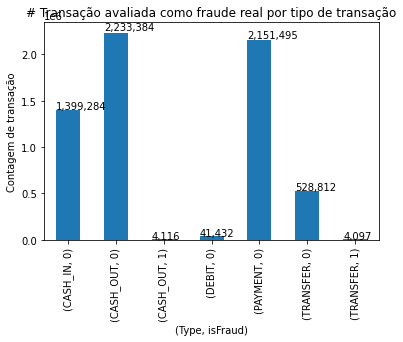

In [12]:
ax = data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title('{:>30}'.format("# Transação avaliada como fraude real por tipo de transação"))
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Contagem de transação")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

- Que tipos de transações são fraudulentas?
- Constatamos que dos cinco tipos de transações, a fraude ocorre apenas em duas delas 'TRANSFER' onde o dinheiro é enviado para um cliente/fraudador e 'CASH_OUT' onde o dinheiro é enviado a um comerciante que paga o cliente/fraudador em dinheiro. Notavelmente, o número de TRANSFERÊNCIAS fraudulentas é quase igual ao número de CASH_OUTs fraudulentos.

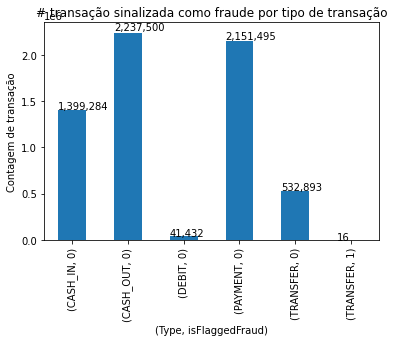

In [13]:
ax = data.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# transação sinalizada como fraude por tipo de transação")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Contagem de transação")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

Parece que a simulação pode sinalizar apenas 16 transações de transferência como fraude. E não conseguiu prever as fraudes de Cash_out. 



In [14]:
(16/6000000) * 100

0.0002666666666666667

In [15]:
fraude = data[(data.isFraud== 1) & (data.isFlaggedFraud== 1)]
fraude.head(16)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08000,C728984460,4953893.08000,4953893.08000,C639921569,0.00000,0.00000,1,1
3247297,250,TRANSFER,1343002.08000,C1100582606,1343002.08000,1343002.08000,C1147517658,0.00000,0.00000,1,1
3760288,279,TRANSFER,536624.41000,C1035541766,536624.41000,536624.41000,C1100697970,0.00000,0.00000,1,1
5563713,387,TRANSFER,4892193.09000,C908544136,4892193.09000,4892193.09000,C891140444,0.00000,0.00000,1,1
5996407,425,TRANSFER,10000000.00000,C689608084,19585040.37000,19585040.37000,C1392803603,0.00000,0.00000,1,1
5996409,425,TRANSFER,9585040.37000,C452586515,19585040.37000,19585040.37000,C1109166882,0.00000,0.00000,1,1
6168499,554,TRANSFER,3576297.10000,C193696150,3576297.10000,3576297.10000,C484597480,0.00000,0.00000,1,1
6205439,586,TRANSFER,353874.22000,C1684585475,353874.22000,353874.22000,C1770418982,0.00000,0.00000,1,1
6266413,617,TRANSFER,2542664.27000,C786455622,2542664.27000,2542664.27000,C661958277,0.00000,0.00000,1,1
6281482,646,TRANSFER,10000000.00000,C19004745,10399045.08000,10399045.08000,C1806199534,0.00000,0.00000,1,1


Considerando que a variável isFlaggedFraud representa apenas 0,00026% do dataset e que todas as 16 previsões de fraude também foram sinalizadas na variável isFraud. Podemos tratar esse recurso como insignificante e descartá-lo no conjunto de dados sem perder informações.

### Limpeza Dos Dados

In [16]:
dataLimpo = data.loc[(data.type == 'TRANSFER') | (data.type == 'CASH_OUT')] # Apenas foi constatado fraude nos tipos Transfer e Cash_out 
randomState = 5
np.random.seed(randomState)
dataLimpo = dataLimpo.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1) #Eliminação de variáveis dispensáveis do dataset

#Feature Engineering

In [17]:
%%time 
def transfer_category(x): #Categorizando os valores de transferência
    if x >= 75000:
        return('HIGH')
    elif x < 75000 and x >= 14000:
        return('MODERATE')
    elif x < 14000:
        return('LOW')
    else:
        return("EXTREMLY LOW")
dataLimpo['transfer_amount_category'] = dataLimpo.amount.apply(transfer_category)    
data.head(2)

CPU times: user 687 ms, sys: 80.5 ms, total: 767 ms
Wall time: 765 ms


In [18]:
%%time
label_encoder = LabelEncoder()  #Transformando textos em números
dataLimpo['type_encode'] = label_encoder.fit_transform(dataLimpo['type']) 
dataLimpo['transfer_amount_category_encode'] = label_encoder.fit_transform(dataLimpo['transfer_amount_category']) 

CPU times: user 1.33 s, sys: 15.1 ms, total: 1.34 s
Wall time: 1.35 s


In [19]:
dataLimpo.type_encode = dataLimpo.type_encode.astype(int)


In [20]:
Y = dataLimpo['isFraud'] #Série com os valore binários 0 ou 1 para identificação de fraude
del dataLimpo['isFraud']

In [21]:
%%time
dataLimpo.head(2)

CPU times: user 228 µs, sys: 19 µs, total: 247 µs
Wall time: 256 µs


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,transfer_amount_category,type_encode,transfer_amount_category_encode
2,1,TRANSFER,181.00000,181.00000,0.00000,0.00000,0.00000,LOW,1,1
3,1,CASH_OUT,181.00000,181.00000,0.00000,21182.00000,0.00000,LOW,0,1


In [22]:
Y

2          1
3          1
15         0
19         0
24         0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 2770409, dtype: int64

In [23]:
dataLimpo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 10 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   step                             int64  
 1   type                             object 
 2   amount                           float64
 3   oldbalanceOrg                    float64
 4   newbalanceOrig                   float64
 5   oldbalanceDest                   float64
 6   newbalanceDest                   float64
 7   transfer_amount_category         object 
 8   type_encode                      int64  
 9   transfer_amount_category_encode  int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 232.5+ MB


In [24]:
%%time
normalizer = Normalizer()
amount_scale = normalizer.fit_transform(dataLimpo.amount.values.reshape(1,-1))
dataLimpo['amount_norm'] = amount_scale.reshape(-1,1)
amount_oldbalanceOrg = normalizer.fit_transform(dataLimpo.oldbalanceOrg.values.reshape(1,-1))
dataLimpo['oldbalanceOrg_norm'] = amount_oldbalanceOrg.reshape(-1,1)
amount_newbalanceOrig = normalizer.fit_transform(dataLimpo.newbalanceOrig.values.reshape(1,-1))
dataLimpo['newbalanceOrig_norm'] = amount_newbalanceOrig.reshape(-1,1)
amount_oldbalanceDest= normalizer.fit_transform(dataLimpo.oldbalanceDest.values.reshape(1,-1))
dataLimpo['oldbalanceDest_norm'] = amount_oldbalanceDest.reshape(-1,1)
amount_newbalanceDest = normalizer.fit_transform(dataLimpo.newbalanceDest.values.reshape(1,-1))
dataLimpo['newbalanceDest_norm'] = amount_newbalanceDest.reshape(-1,1)

CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 200 ms


In [25]:
%%time
dataLimpo.head(2)

CPU times: user 188 µs, sys: 16 µs, total: 204 µs
Wall time: 209 µs


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,transfer_amount_category,type_encode,transfer_amount_category_encode,amount_norm,oldbalanceOrg_norm,newbalanceOrig_norm,oldbalanceDest_norm,newbalanceDest_norm
2,1,TRANSFER,181.00000,181.00000,0.00000,0.00000,0.00000,LOW,1,1,0.00000,0.00000,0.00000,0.00000,0.00000
3,1,CASH_OUT,181.00000,181.00000,0.00000,21182.00000,0.00000,LOW,0,1,0.00000,0.00000,0.00000,0.00000,0.00000


## Modelagem

Na etapa de modelagem vamos construir alguns modelos para executar a tarefa de classificação das transações que são fraude e transações que não são fraude.

### Split - Treino/Teste

In [39]:
%%time
X = dataLimpo[['type_encode', 'transfer_amount_category_encode','amount_norm',
          'oldbalanceOrg_norm','newbalanceOrig_norm',
          'oldbalanceDest_norm','newbalanceDest_norm']]
y = Y
X_train, X_test, y_train, y_test = cpu_train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    stratify=y,
                                                    random_state = 42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
dadosTreino = pd.concat([X_train, y_train], axis = 1)
dadosTeste = pd.concat([X_test, y_test], axis = 1)

CPU times: user 1.84 s, sys: 572 ms, total: 2.41 s
Wall time: 2.42 s


# Modelagem, Tunning, Treino e Métrica - Árvore de Decisão

In [120]:
%%time
# Parametrização DecisionTree
parametros = {  'criterion': ['gini', 'entropy'],
                    'max_depth' :[2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
                    'min_samples_split': [10, 20, 30, 40, 50], 
                    }

modelo = DecisionTreeClassifier()

# Tunning dos parâmetros
arvore = RandomizedSearchCV(modelo, 
                            param_distributions = parametros,
                            scoring = 'f1', 
                            cv = validacao,
                            n_iter = 2, 
                            n_jobs = -1)

# Treino e Metrificação
arvore.fit(X_train, y_train)
predicoes = arvore.predict(X_test)
y_arvore_proba = arvore.predict_proba(X_test) #Função probabilidade
acc = accuracy_score(y_test,predicoes)
sen = recall_score(y_test,predicoes)
pre = precision_score(y_test,predicoes)
f1s = f1_score(y_test,predicoes)
auc = roc_auc_score(y_test,y_arvore_proba[:, 1])

medidas = {'Acurácia': [acc], 'Sensibilidade': [sen], 'Precisão': [pre], 'F1-Score': [f1s], 'AUC': [auc]}

print(classification_report(predicoes, y_test, digits = 4)[:220])

print('Matriz de Confusão:\n\n', confusion_matrix(y_test,predicoes))

Arvore = pd.DataFrame(medidas, index = ["Arvore Simples"]).round(4),arvore

              precision    recall  f1-score   support

           0     0.9999    0.9989    0.9994    912464
           1     0.6192    0.9475    0.7489      1771

    accuracy                         0.9988    914235
  
Matriz de Confusão:

 [[911432     93]
 [  1032   1678]]
CPU times: user 14.6 s, sys: 345 ms, total: 14.9 s
Wall time: 56.1 s


In [121]:
Arvore[0]

,Acurácia,Sensibilidade,Precisão,F1-Score,AUC
Arvore Simples,0.99880,0.61920,0.94750,0.74890,0.93140


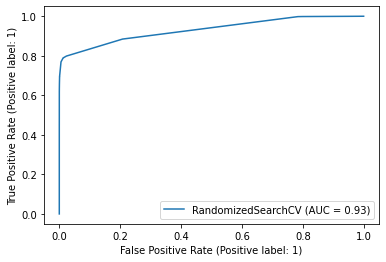

In [122]:
plot_roc_curve(arvore, X_test, y_test)

# Modelagem, Tunning, Treino e Métrica- RandomForest(Floresta Aleatória)

In [124]:
%%time
#Parametrização RandomForest
parametros = { 'n_estimators': [5],
                  'criterion':['gini','entropy'],
                   'random_state':[42]
                    }

modelo = cpu_RandomForestClassifier()

#Tunning Random Forest
floresta = RandomizedSearchCV(modelo, 
                            param_distributions = parametros,
                            scoring = 'f1', 
                            cv = validacao,
                            n_iter = 2, 
                            n_jobs = -1)

#Treino e Metrificação Random Forest
floresta.fit(X_train, y_train)

predicoes = floresta.predict(X_test)
y_floresta_proba = floresta.predict_proba(X_test)
acc = accuracy_score(y_test,predicoes)
sen = recall_score(y_test,predicoes)
pre = precision_score(y_test,predicoes)
f1s = f1_score(y_test,predicoes)
auc = roc_auc_score(y_test,y_floresta_proba[:,1])

medidas = {'Acurácia': [acc], 'Sensibilidade': [sen], 'Precisão': [pre], 'F1-Score': [f1s], 'AUC': [auc]}

print(classification_report(predicoes, y_test, digits = 4)[:220])

print('Matriz de Confusão:\n\n', confusion_matrix(y_test,predicoes))

Floresta = pd.DataFrame(medidas, index = ['Floresta Aleatoria']).round(4), floresta

              precision    recall  f1-score   support

           0     0.9999    0.9993    0.9996    912150
           1     0.7509    0.9760    0.8488      2085

    accuracy                         0.9992    914235
  
Matriz de Confusão:

 [[911475     50]
 [   675   2035]]
CPU times: user 33.9 s, sys: 554 ms, total: 34.4 s
Wall time: 2min 46s


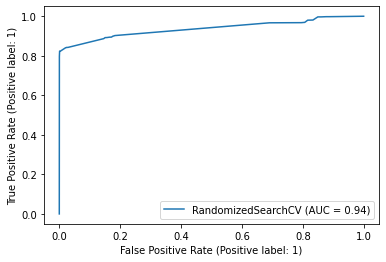

In [125]:
plot_roc_curve(floresta, X_test, y_test)

In [126]:
Floresta[0]

,Acurácia,Sensibilidade,Precisão,F1-Score,AUC
Floresta Aleatoria,0.99920,0.75090,0.97600,0.84880,0.93740


### Treinamento do modelo - XGBoost

In [34]:
%%time

# Parametrização do XGBoost
params = {'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'objective': 'binary:logistic',
          'alpha' : 10,
          'n_estimators': 100}

# Treinamento do modelo XGBoost
cpu_trained_model = XGBClassifier(**params)
cpu_trained_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='auc', verbose=False)

CPU times: user 3min 28s, sys: 626 ms, total: 3min 29s
Wall time: 3min 28s


In [35]:
%%time
# Predições
y_pred_cpu = cpu_trained_model.predict(X_test) 

CPU times: user 3.54 s, sys: 3.9 ms, total: 3.55 s
Wall time: 3.55 s


In [104]:
y_pred_proba =cpu_trained_model.predict_proba(X_test)

In [106]:
%%time
print(y_pred_proba[:1])

[[9.9953192e-01 4.6808037e-04]]
CPU times: user 2.73 ms, sys: 0 ns, total: 2.73 ms
Wall time: 5.96 ms


In [107]:
%%time
acc = accuracy_score(y_test,y_pred_cpu)
sen = recall_score(y_test,y_pred_cpu)
pre = precision_score(y_test,y_pred_cpu)
f1s = f1_score(y_test,y_pred_cpu)
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

medidas = {'Acurácia': [acc], 'Sensibilidade': [sen], 'Precisão': [pre], 'F1-Score': [f1s], 'AUC': [auc]}

print(classification_report(y_test,y_pred_cpu, digits = 4)[:220])

print('Matriz de Confusão:\n\n', confusion_matrix(y_test,y_pred_cpu))

Xboost = pd.DataFrame(medidas, index = ['XBoost']).round(4), cpu_trained_model

              precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995    911525
           1     0.9935    0.6797    0.8072      2710

    accuracy                         0.9990    914235
  
Matriz de Confusão:

 [[911513     12]
 [   868   1842]]
CPU times: user 5.21 s, sys: 52.7 ms, total: 5.26 s
Wall time: 8.33 s


In [108]:
Xboost[0]

,Acurácia,Sensibilidade,Precisão,F1-Score,AUC
XBoost,0.99900,0.67970,0.99350,0.80720,0.98810


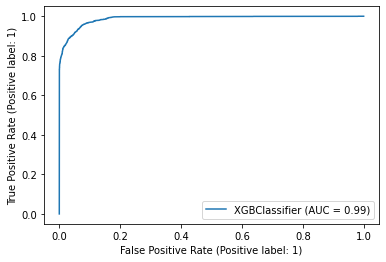

In [94]:
plot_roc_curve(cpu_trained_model, X_test, y_test)

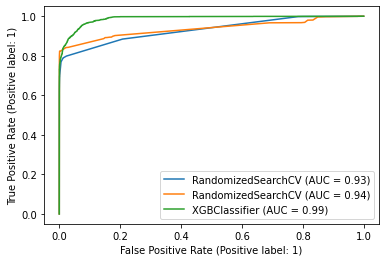

In [131]:
# Comparação das  AUC
classifiers = [arvore, floresta,cpu_trained_model]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

# Ajuste de Corte Xboost

In [138]:
from sklearn.metrics import precision_recall_curve 
propensoes = Xboost[1].predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, propensoes)

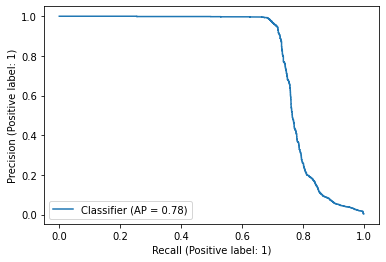

In [139]:
from sklearn.metrics import PrecisionRecallDisplay 
import matplotlib.pyplot as plt
PrecisionRecallDisplay.from_predictions(y_test, propensoes)
plt.show()

In [147]:
#custos do modelo considerando que para detecão de fraude a sensibilidade é mais importante que a precisão
s = 2
p = 1

aux = pd.DataFrame({ 'Sensibilidade': recall[1:], 'Precisao': precision[1:], 'Corte': thresholds })
aux['Custo'] = (p*aux['Precisao'] + s*aux['Sensibilidade'])/(p+s)
aux.sort_values(by = 'Custo', ascending = False)

,Sensibilidade,Precisao,Corte,Custo
124676,0.71661,0.94917,0.15671,0.79413
124675,0.71661,0.94871,0.15490,0.79397
124674,0.71661,0.94824,0.15239,0.79382
124673,0.71661,0.94778,0.15225,0.79366
124672,0.71661,0.94732,0.15109,0.79351
...,...,...,...,...
125362,0.00332,1.00000,0.99507,0.33555
125363,0.00295,1.00000,0.99519,0.33530
125364,0.00258,1.00000,0.99528,0.33506
125365,0.00037,1.00000,0.99550,0.33358


No melhor corte da curva auc o Xboost apresenta uma sensibilidade de 0.71. ainda menor que a floresta aleatória

## Conclusões

In [128]:
pd.concat([Arvore[0], Floresta[0], Xboost[0]])

,Acurácia,Sensibilidade,Precisão,F1-Score,AUC
Arvore Simples,0.99880,0.61920,0.94750,0.74890,0.93140
Floresta Aleatoria,0.99920,0.75090,0.97600,0.84880,0.93740
XBoost,0.99900,0.67970,0.99350,0.80720,0.98810


##### Como está a nossa detecção de fraudes nesta solução proposta?

Para esse cenário, o melhor modelo de detecção de fraude é a Random Forest. pois para esse tipo de modelo o custo de ter um falso negativo é maior do que um falso positivo, afinal prever uma transação fraudulenta(Verdadeiro positivo) como não fraudulenta(Falso Negativo) vai gerar consequências piores do que rotular incorretamente uma transação inofensiva como fraudulenta.

Com esse modelo, 75% das fraudes foram detectadas corretamente com uma taxa verdadeiros negativos bem pequena (50 transações).

O tempo para rodar o modelo também foi relativamente rápido com apenas aproximadamente 3 min de duração.

#Variáveis mais importantes

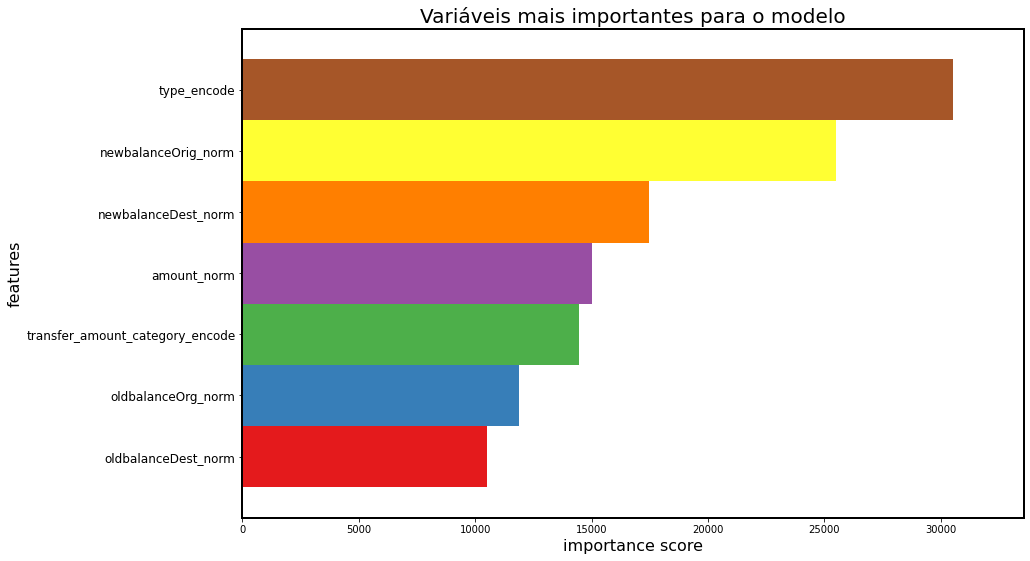

In [135]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(cpu_trained_model, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Variáveis mais importantes para o modelo', size = 20);

Analisando as principais features, podemos inferir alguns pontos como:
- É importante dar uma atenção especial aos tipos de transações "Transfer" e 'Cash_Out', como visto na EDA, elas foram as únicas utilizadas para fraudar.
- Os novos saldos das contas de origem e  destino. Provavelmente há maior movimentação entre essas contas. Além disso, geralmente a conta de destino está zerada antes da transação e a conta de origem geralmente tem um novo saldo menor do que antes da transação.

### Tempo de Inferência

##### Por que o tempo de inferência é importante?

O tempo de inferência está diretamente ligado aos requisitos para colocar um modelo de Machine Learning em produção. Portanto, analisar as métricas de desempenho do modelo é fundamental, mas não é o único aspecto a ser levado em consideração ao definir que o modelo obtido atende todos os requisitos.
